In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%run Helper_Functions.ipynb

In [ ]:
dataBuffer = []
for mousename in ['BV160', 'BV163', 'BV165', 'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    exptListAll = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'PreGOL') or (expt.experimentType == 'GOL') or \
                  (expt.experimentType == 'PostGOL')]
    
    print(str(len(exptListAll)) + ' experiments:')
    count = 0
    for expt in exptListAll:
        print(str(count)+ ', ' ),
        count = count + 1
        
        if expt.experimentType == 'GOL':
            dataBuffer.append({'mouse': mousename,
                'day': expt.day,                 
                'session': expt.session,
                'exptType': expt.experimentType,  
                'startTime': expt.startTime(),              
                'laps': expt.laps})  
        else:
            ripple_frames = loadRippleFrames(expt)
            
            filepath = expt.LFPFilePath() + '/Ripple_Properties.pkl'
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
            durations = data['ripple_durations']
            
            dataBuffer.append({'mouse': mousename,
                'day': expt.day,
                'session': expt.session,
                'exptType': expt.experimentType,   
                'startTime': expt.startTime(),                 
                'n_ripples': len(ripple_frames),
                'durations': durations})   
    
dataBuffer = pd.DataFrame(dataBuffer)

In [ ]:
summary_data = []
for mousename in ['BV160', 'BV163', 'BV165', 'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    for day in np.unique(dataBuffer[dataBuffer.mouse == mousename]['day'].values):
        
        pre_durations = np.concatenate(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.exptType == 'PreGOL'][dataBuffer.day == day]['durations'].values)
        post_durations = np.concatenate(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.exptType == 'PostGOL'][dataBuffer.day == day]\
            [dataBuffer.session == 3]['durations'].values)
        
        mean_pre_durations = np.nanmean(pre_durations)
        mean_post_durations = np.nanmean(post_durations)
        delta_durations = np.nanmean(post_durations) - np.nanmean(pre_durations)
        
        pre_n_ripples = np.nansum(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.exptType == 'PreGOL'][dataBuffer.day == day]['n_ripples'].values)
        post_n_ripples = dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.exptType == 'PostGOL'][dataBuffer.day == day]\
            [dataBuffer.session == 3]['n_ripples'].values[0]
        
        GOL_start_time = dataBuffer[dataBuffer.mouse == mousename][dataBuffer.day == day]\
            [dataBuffer.exptType == 'GOL']['startTime'].values[0]
        S3_start_time = dataBuffer[dataBuffer.mouse == mousename][dataBuffer.day == day]\
            [dataBuffer.exptType == 'PostGOL'][dataBuffer.session == 3]['startTime'].values[0]
        time_delta = pd.Timedelta(S3_start_time - GOL_start_time).total_seconds()/float(60)
        
        summary_data.append({'mouse': mousename, 'day': day,
            'Time_Delta': time_delta,
            'Mean_Pre_Durations': mean_pre_durations,
            'Mean_Post_Durations': mean_post_durations,
            'Delta_Durations': delta_durations,
            'Pre_n_Ripples': pre_n_ripples,
            'Post_n_Ripples': post_n_ripples})  

summary_data = pd.DataFrame(summary_data)

In [6]:
summary_data = summary_data[summary_data.Time_Delta < 40]

In [7]:
pre_durations = summary_data.Mean_Pre_Durations.values
post_durations = summary_data.Mean_Post_Durations.values

In [11]:
data = [summary_data.Mean_Pre_Durations.values, summary_data.Mean_Post_Durations.values]
data = pd.melt(pd.DataFrame(np.transpose(data)))
data = data.rename(columns = {'variable':'Session_Type', 'value':'Mod_Value'})
day = np.tile(range(len(summary_data.Mean_Pre_Durations)),2)
data['Day'] = day

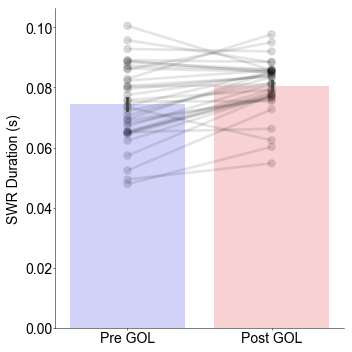

In [12]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
colors = ['blue', 'red']
for i in range(len(np.unique(data.Day))):
    g = sns.pointplot(x = 'Session_Type', y = 'Mod_Value', data = data[data.Day == i], color = 'black')
plt.setp(g.collections, alpha=.1) #for the markers
plt.setp(g.lines, alpha=.1)       #for the lines   
    
bar_data = [pre_durations, post_durations]    
sns.barplot(data = bar_data, ci = 68, alpha = 0.2, palette = colors)

ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_xlabel('')
ax.set_ylabel('SWR Duration (s)', fontsize = 14)
ax.set_xticklabels(['Pre GOL', 'Post GOL'])

simpleaxis(ax)
fig.tight_layout()
plt.savefig('GOL_Pre_Post_SWR_Durations.svg', format = 'svg', dpi = 1200, \
            transparent = True)